<a href="https://colab.research.google.com/github/hrkzz/Bayesian_stats_with_Pystan/blob/master/pystan1_%E5%8D%98%E5%9B%9E%E5%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#基本ライブラリ
import numpy as np
import pandas as pd

#図形描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

from matplotlib.pylab import rcParams

# 統計モデル
import statsmodels.formula.api as smf
import pystan

#単回帰

StanとRでベイズ統計モデリング第4章をPystanで実装

参考<br>
https://github.com/MatsuuraKentaro/RStanBook<br>
https://qiita.com/shngt/items/bfb790bbdce98e899553

##データ

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/MatsuuraKentaro/RStanBook/master/chap04/input/data-salary.txt')

Xは年齢、Yは年収（万円）<br>
Yは基本年収である$y_{base}$とそれ以外の影響である$\varepsilon$の和とする。

In [6]:
data.head()

,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


In [26]:
data.shape

(20, 2)

In [32]:
data.describe()

,X,Y
count,20.000000,20.000000
mean,43.350000,829.850000
std,11.952868,272.902966
min,24.000000,403.000000
25%,34.500000,594.500000
50%,43.000000,803.000000
75%,56.000000,1028.250000
max,59.000000,1314.000000


##図示

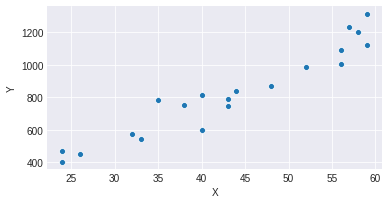

In [11]:
rcParams['figure.figsize'] = 6,3
sns.scatterplot(x=data.X, y=data.Y)

##モデル

$$
\begin{align}
    Y[n] &= y_{base}[n]+\varepsilon[n] \quad n=1..N \\
    y_{base}[n] &=a+bX[n] \quad\quad n=1..N\\
    \varepsilon[n] & \sim Normal(0,\sigma)\quad n=1..N
\end{align}
$$

##StatsmodelのOLSで推定

In [79]:
model = smf.ols('Y ~ X', data=data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     208.2
Date:                Wed, 01 May 2019   Prob (F-statistic):           2.47e-11
Time:                        12:59:47   Log-Likelihood:                -114.74
No. Observations:                  20   AIC:                             233.5
Df Residuals:                      18   BIC:                             235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -119.6971     68.148     -1.756      0.0

##Stanで実装

先ほどのモデルは次のように書き換え可能
$$
    Y[n] \sim Normal(a+bX[n],\sigma)\quad n=1..N
$$

Stanの式は次のとおり。なお、Stanでは事前分布を指定しないと自動的に制限された範囲内で十分に幅の広い一様分布が使われる。

In [166]:
model4_5 = '''
data{
    int N;
    real X[N];
    real Y[N];
}

parameters{
    real a;
    real b;
    real<lower=0> sigma;
}

model{
    for (n in 1:N){
      Y[n] ~ normal(a + b*X[n], sigma);
    }
}
'''

data_stan = {'N':data.shape[0], 'X':data.X, 'Y':data.Y}
fit = pystan.stan(model_code=model4_5, data=data_stan,seed=1234)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a9084fcbf58c6bc9f5a948b896ff6f83 NOW.


##結果の見方

In [167]:
print(fit)

Inference for Stan model: anon_model_a9084fcbf58c6bc9f5a948b896ff6f83.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -123.5    2.04   76.4 -272.3 -169.8 -122.9  -73.9  26.33   1404    1.0
b       22.0    0.05    1.7  18.68  20.89  21.97  23.06  25.38   1361    1.0
sigma  85.34    0.42  15.62  61.78  73.94  83.32  94.41  121.4   1376    1.0
lp__  -93.65    0.04   1.33 -97.01 -94.26 -93.31 -92.68 -92.14    873    1.0

Samples were drawn using NUTS at Wed May  1 13:43:08 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


1行目はモデルのファイル名<br>
2行目にはMCMCのchain数、iterationのステップ数、warmupのステップ数、thinningのステップ数が表示。今回はデフォルトの設定。MCMCのサンプルの長さは<br><br>
$$
  \frac{chains*(iterations - warmup)}{thinning}
$$
<br>
になるので、今回は4000となる。

meanはMCMCのサンプルの平均値で事後平均と呼ばれる。se_meanはmeanの標準誤差。sdは標準偏差。2.5%～97.5%はどｔｒぉｔｒの分位点。n_effはStanが自己相関等あkら判断した実効的なMCMCサンプル数。著者によると100くらいが望ましい。RhatはMCMCの収束の判断のひとつ。1.1以下だと収束とみなせる。

##結果の図示

一括してみたい場合は`fit.plot()`が便利

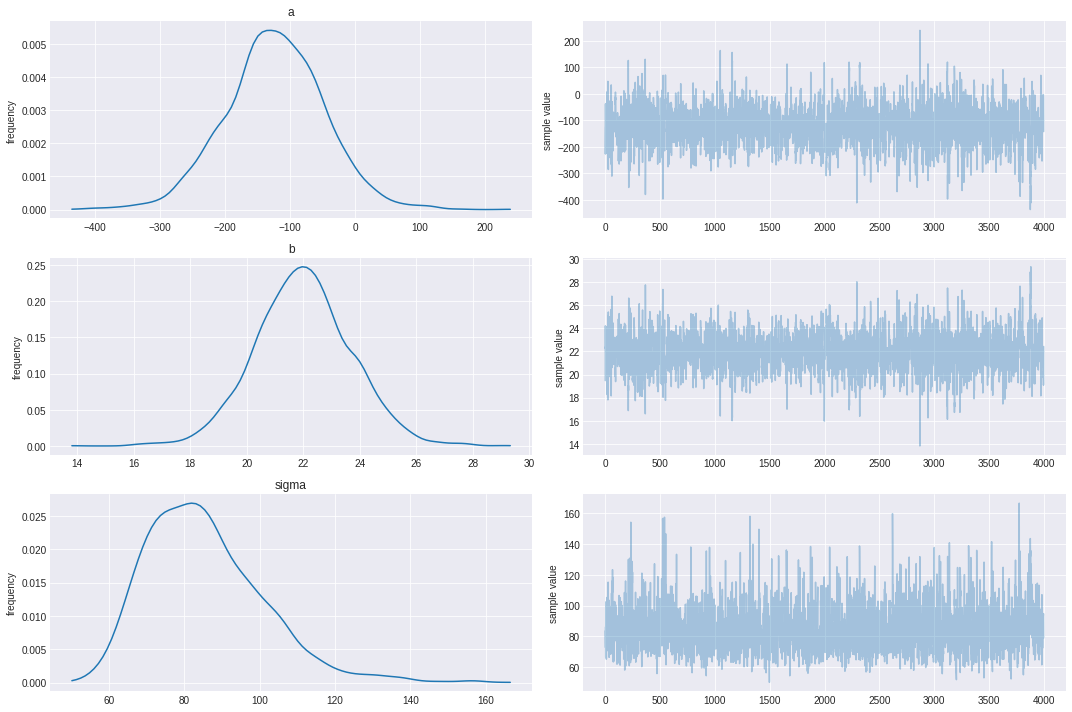

In [174]:
rcParams['figure.figsize'] = 15, 10
fit.plot()
plt.tight_layout()
plt.show()

また、シミュレーション結果は`fit.extract`に格納されているので、こちらを利用しても図示ができる。

In [0]:
#MCMCサンプリング結果の抽出（トレースプロットを見るので全て抽出）
ms  = fit.extract(permuted=False, inc_warmup=True)

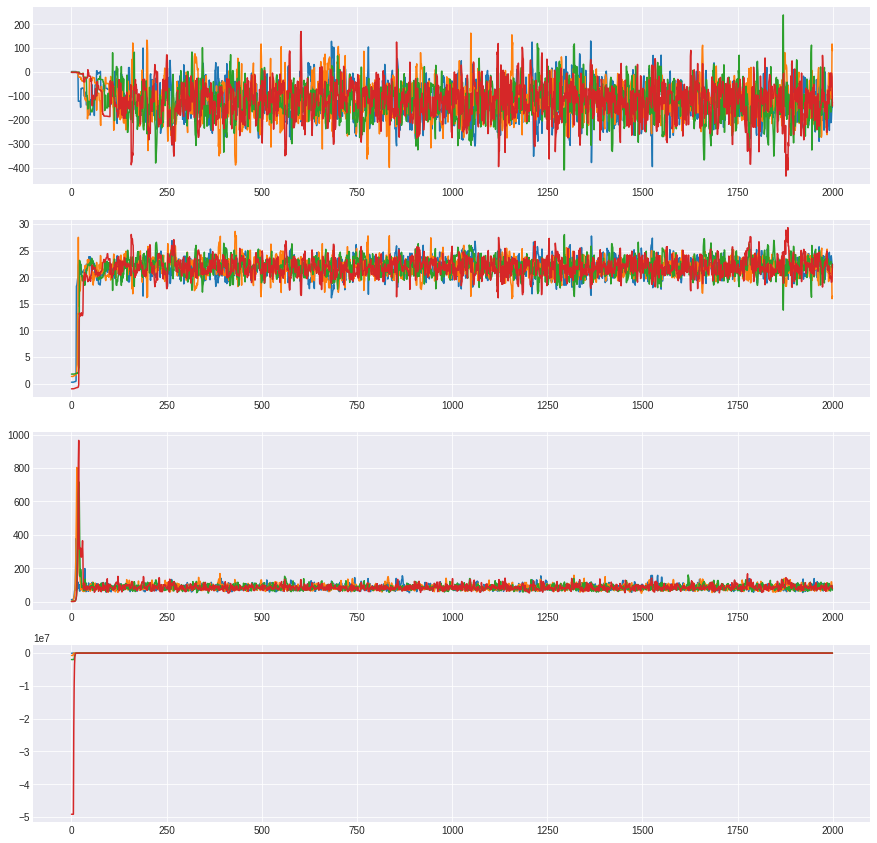

In [219]:
rcParams['figure.figsize'] = 15, 15

#パラメータa
plt.subplot(411)
for i in range(0,4):
  plt.plot(ms [:,i,0])

#パラメータb
plt.subplot(412)
for i in range(0,4):
  plt.plot(ms [:,i,1])

#パラメータsigma
plt.subplot(413)
for i in range(0,4):
  plt.plot(ms [:,i,2])

#パラメータlp__
plt.subplot(414)
for i in range(0,4):
  plt.plot(ms [:,i,3])
  

##MCMCの設定の変更

###Sampling

`model4_5.stan`というStanファイルを作成。`pystan.StanModel`と`sampling`を組み合わせることで、最初のコンパイルの時間を削減。GitHubからうまく持ってこれなかったので、力業で持ってきました…。

In [235]:
from google.colab import files
uploaded = files.upload()

Saving model4_5.stan to model4_5.stan


In [238]:
stanmodel = pystan.StanModel(file='model4_5.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c29b7df77ee191df2836ddb92bdbccc0 NOW.


Samplingのほかに、seed、chains、iter、thin等の設定を変更することが出来ます。

In [0]:
fit = stanmodel.sampling(data=data_stan, seed=1, chains=4, iter=5000, warmup=200, thin=2)

サンプリングをかますだけで驚くほど速くなっています。。。

In [250]:
print(fit)

Inference for Stan model: anon_model_c29b7df77ee191df2836ddb92bdbccc0.
4 chains, each with iter=5000; warmup=200; thin=2; 
post-warmup draws per chain=2400, total post-warmup draws=9600.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -121.9    0.94  74.15 -267.6 -170.5 -121.3 -73.92  25.53   6161    1.0
b      21.96    0.02   1.66  18.65  20.88  21.95  23.03  25.23   6126    1.0
sigma  85.09    0.19  15.36  61.49  74.22  83.12  93.58 120.15   6370    1.0
lp__  -93.63    0.02    1.3 -96.92 -94.23 -93.29 -92.67 -92.14   4916    1.0

Samples were drawn using NUTS at Wed May  1 15:06:53 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


##並列計算の実行方法

In [245]:
#モデルの保存にはpickleを利用
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(fit, f, protocol=pickle.HIGHEST_PROTOCOL)
    
# 並列計算はn_jobsで指定
stanmodel.sampling(data=data_stan, n_jobs=-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


Inference for Stan model: anon_model_c29b7df77ee191df2836ddb92bdbccc0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -120.6    2.31   73.1 -260.7 -168.2 -122.1 -72.74  29.19   1005   1.01
b      21.93    0.05   1.63  18.57  20.86  21.96  23.02  25.03    932   1.01
sigma  84.67    0.39  15.95  59.94  73.36  82.21  92.67 121.63   1663    1.0
lp__  -93.68    0.04   1.36 -97.33 -94.27 -93.33 -92.67 -92.14   1053    1.0

Samples were drawn using NUTS at Wed May  1 15:05:27 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

##ベイズ信頼区間とベイズ予測区間の算出

In [0]:
#色々と紹介してきたので、改めてモデルへの当てはめを実行。
fit = stanmodel.sampling(data=data_stan, seed=1, chains=3, iter=1000, warmup=200, thin=2, n_jobs=-1)

In [290]:
fit

Inference for Stan model: anon_model_c29b7df77ee191df2836ddb92bdbccc0.
3 chains, each with iter=1000; warmup=200; thin=2; 
post-warmup draws per chain=400, total post-warmup draws=1200.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -126.4    2.32  70.12 -267.8 -172.3 -126.6 -81.34   8.47    916    1.0
b      22.06    0.05   1.55   19.0  21.05  22.06  23.07   25.2    906    1.0
sigma  84.53    0.53  14.99  61.93   73.9  82.65  92.93 118.45    795    1.0
lp__  -93.57    0.05   1.24  -96.9 -94.16  -93.3 -92.67 -92.13    538    1.0

Samples were drawn using NUTS at Wed May  1 15:16:34 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [0]:
#with open('model.pkl', 'rb') as f:
#    fit = pickle.load(f)
ms = fit.extract(permuted=True, inc_warmup=False)

In [284]:
#パラメータbを抽出
ms['b']

array([21.75138928, 20.91262168, 20.44933087, ..., 25.89994691,
       21.36134965, 22.33340595])

In [285]:
#95%
np.percentile(ms['b'], (2.5, 97.5))

array([19.0000316 , 25.15903856])

In [286]:

d_mcmc = pd.DataFrame(data=dict(a=ms['a'], b=ms['b'], sigma=ms['sigma']))
d_mcmc.head()

,a,b,sigma
0,-136.907809,21.751389,67.194049
1,-92.622425,20.912622,71.862617
2,-42.338950,20.449331,94.862677
3,-215.951766,23.606235,93.631041
4,-151.994948,22.745231,85.235540


In [288]:
d_mcmc.shape

(1200, 3)

In [289]:
d_mcmc.describe()

,a,b,sigma
count,1200.000000,1200.000000,1200.000000
mean,-126.493058,22.064724,84.533140
std,70.119855,1.554263,14.985800
min,-388.182863,17.248514,49.968207
25%,-172.348451,21.051125,73.921355
50%,-126.667319,22.057943,82.652004
75%,-81.405422,23.066201,92.929570
max,128.476508,27.396394,151.008776


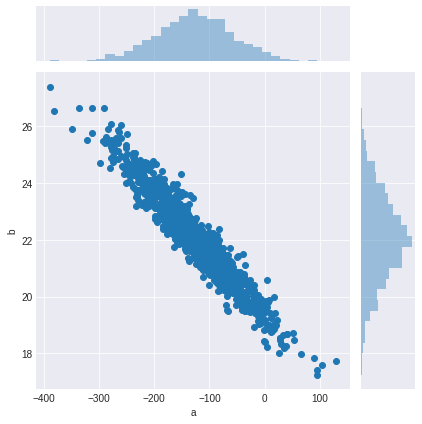

In [294]:
sns.jointplot('a', 'b', data=d_mcmc)
plt.show()

##推定

In [300]:
N_mcmc = len(ms['lp__'])
y50_base = ms['a'] + ms['b'] * 50
y50 = np.random.normal(loc=y50_base, scale=ms['sigma'], size=N_mcmc)
d_mcmc = pd.DataFrame(data=dict(a=ms['a'], b=ms['b'], sigma=ms['sigma'], y50_base=y50_base, y50=y50))
d_mcmc.head()

,a,b,sigma,y50_base,y50
0,-136.907809,21.751389,67.194049,950.661655,1019.271500
1,-92.622425,20.912622,71.862617,953.008659,990.076431
2,-42.338950,20.449331,94.862677,980.127593,960.393911
3,-215.951766,23.606235,93.631041,964.359999,944.010847
4,-151.994948,22.745231,85.235540,985.266625,1156.908533


In [0]:
ages = X_new['X']
steps = ages.size
median = np.empty(steps)
conf50 = np.empty((steps, 2))
conf95 = np.empty((steps, 2))
pred50 = np.empty((steps, 2))
pred95 = np.empty((steps, 2))
np.random.seed(1234)

for i, age in enumerate(ages):
    base = ms['a'] + ms['b'] * age
    y = np.random.normal(loc=base, scale=ms['sigma'], size=N_mcmc)
    median[i] = np.median(base)
    conf50[i] = np.percentile(base, (25, 75))
    pred50[i] = np.percentile(y, (25, 75))
    conf95[i] = np.percentile(base, (2.5, 97.5))
    pred95[i] = np.percentile(y, (2.5, 97.5))

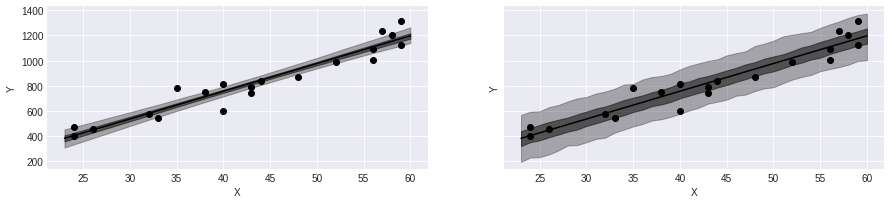

In [317]:
_, axes = plt.subplots(1, 2, sharex=True, sharey=True)
for interval50, interval95, ax in zip([conf50, pred50], [conf95, pred95], axes):
    color='k'
    ax.scatter('X', 'Y', data=data, c=color)
    ax.plot(ages, median, c=color)
    ax.fill_between(ages, interval50[:, 0], interval50[:, 1], color=color, alpha=0.5)
    ax.fill_between(ages, interval95[:, 0], interval95[:, 1], color=color, alpha=0.3)
    plt.setp(ax, xlabel='X', ylabel='Y')
plt.show()